In [1]:
%matplotlib inline
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
from src.preprocessing.computer_vision import augmentation, scaling, resize
from src.projects.domainnet.architecture import FCNDomainNet, CNNDomainNet

/Users/gianrond/miniforge3/envs/tensorflow_ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-12-11 11:40:36.071981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 11:40:36.072112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
_log = getLogger()
generic_path = Path(os.getcwd()) / Path('trained_models')
specific_name = Path('domainnet')
model_save_fp = generic_path / specific_name
tensorboard_logdir = generic_path / Path('tensorboard_logs') / specific_name
checkpoint_logdir = model_save_fp / Path('checkpoints')

In [4]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    "domainnet/real", as_supervised=True, split=["train[:85%]", "train[85%:]", "test"]
)
_, info = tfds.load(
    "domainnet/real", as_supervised=True, with_info=True,
)

In [5]:
# Labels
class_names = info.features["label"].names
print(class_names)

['aircraft_carrier', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball_bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan', 'cello', 'cell_phone', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship', 'cup', 'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 

Plotting some random images with their label

In [6]:
def plot_random_images(dataset: tf.data.Dataset, sample_size :int):
    random_images = []
    sqrt_sample = int(np.sqrt(sample_size))

    for el in dataset.shuffle(1000).take(sqrt_sample*sqrt_sample):
        image, label = el
        label_name = class_names[label.numpy()]
        random_images.append((label_name, image))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img_tuple, ax in zip(random_images, axs.ravel()):
        label, img = img_tuple
        ax.imshow(tf.cast(img, dtype=tf.int64), )
        ax.set_title(label)
    plt.show()


2022-12-11 11:40:36.334094: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


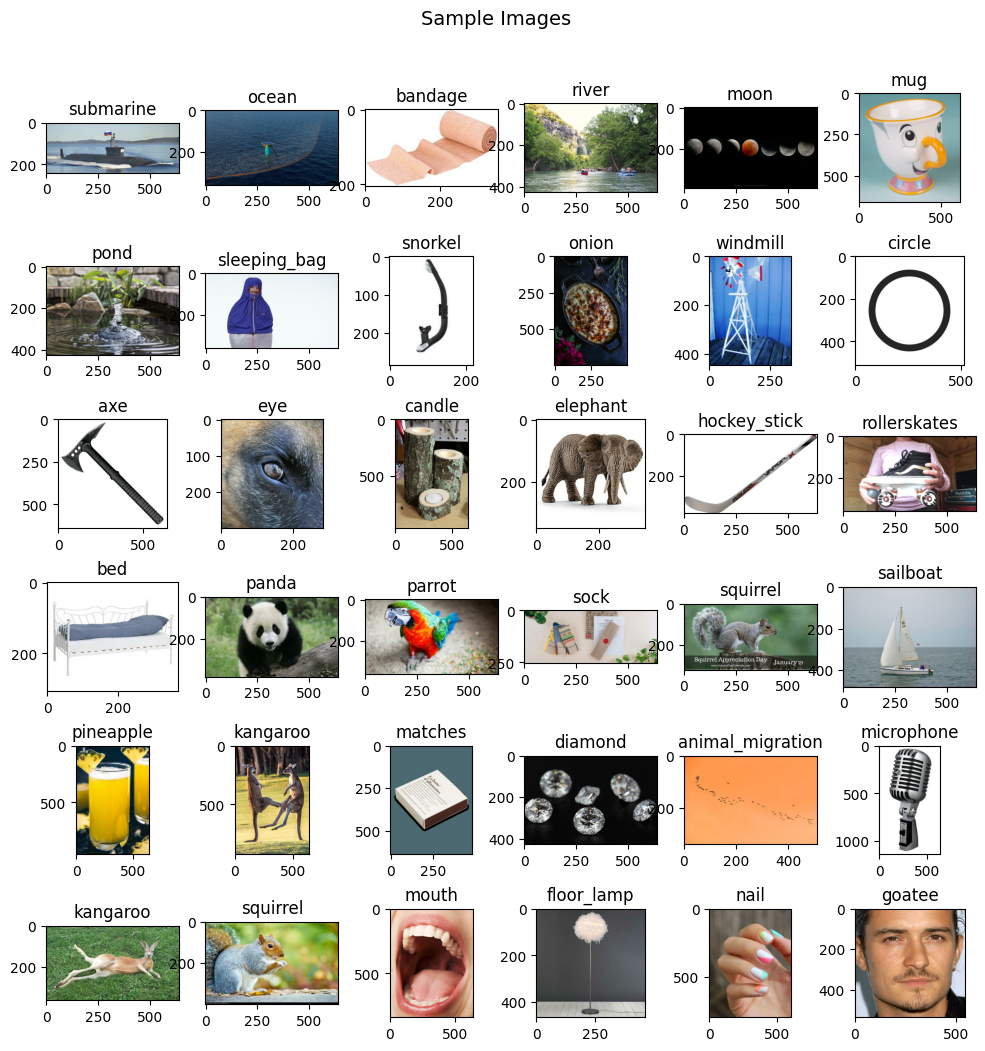

In [7]:
plot_random_images(train_dataset, 36)

The next steps will be about preprocessing the images: we will randomly flip them, adjust the brightness and the contrast. Images have all different sizes and aspect ratios, so we will aloso resize and crop them for normalization

In [8]:
target_image_height = 128
target_image_width = 128
train_dataset = train_dataset.map(lambda image, label: (resize(image, target_image_height, target_image_width), label))
train_dataset = train_dataset.map(lambda image, label: (augmentation(image), label))
train_dataset = train_dataset.map(lambda image, label: (scaling(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (resize(image, target_image_height, target_image_width), label))
validation_dataset = validation_dataset.map(lambda image, label: (scaling(image), label))

In [9]:
batch_size = 64
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

We will now train two similar models, one that has a final Dense layer ('CNNNetwork'), and another that is a fully connected CNN network where the final output layer is also a convolutional one, with a Global Max Pooling layer

Model: "CNNDomainNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                  

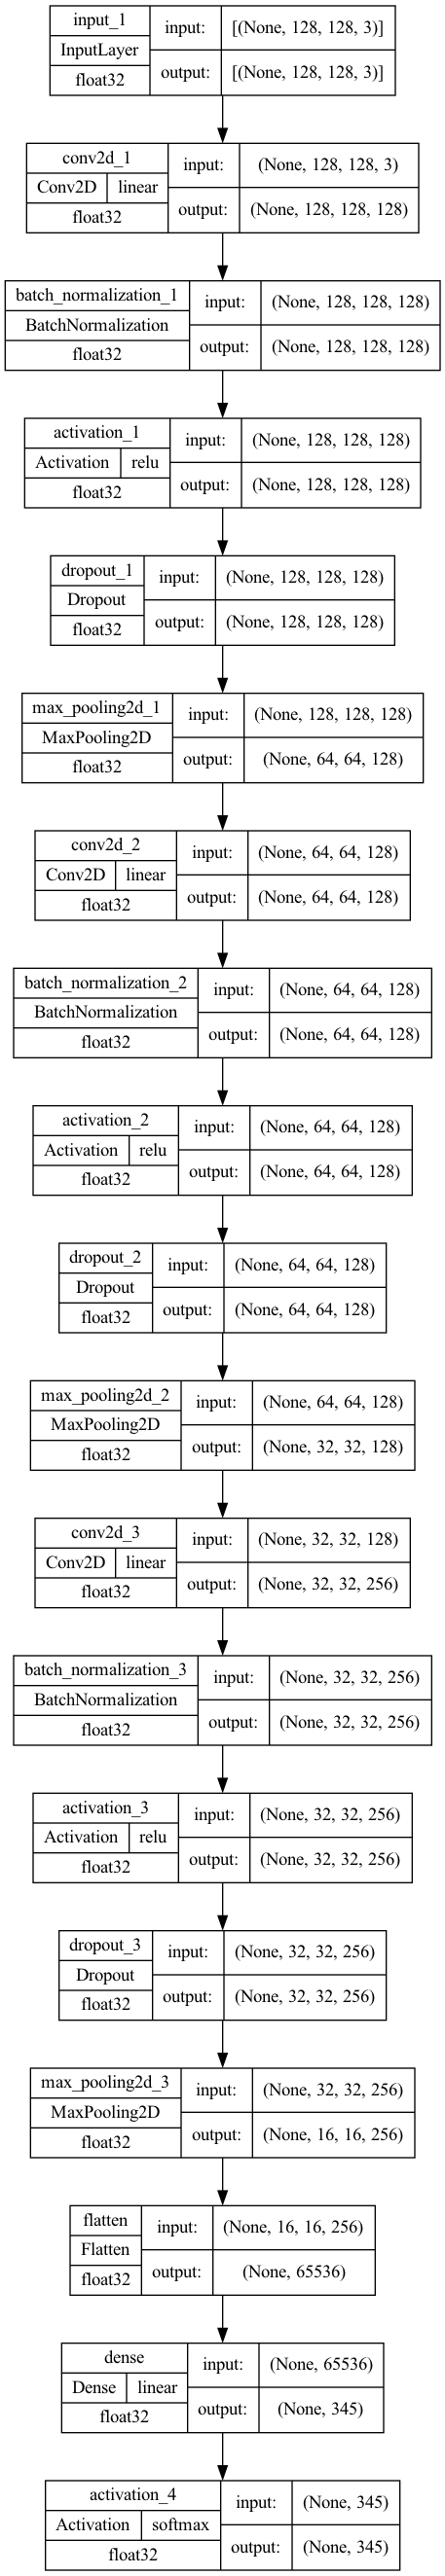

In [10]:
name = 'CNNDomainNet'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name) / Path(str(datetime.datetime.now()))
with mirrored_strategy.scope():
    model = CNNDomainNet(name=name, filepath=artifacts_path)
model = model.connect_layers()

In [11]:
epochs = 200
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(
        checkpoint_logdir=checkpoint_logdir,
        tensorboard_logdir=str(tensorboard_run_path)
    ),
    steps_per_epoch=2000,
    validation_steps=2000,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Epoch 1/200


2022-12-11 11:40:39.272087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 277/2000 [===>..........................] - ETA: 4:35 - loss: 30.1236 - accuracy: 0.0084

KeyboardInterrupt: 

In [ ]:
test_dataset = test_dataset.map(lambda image, label: (scaling(image), label))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [8]:
model_paths = {
    'CNNNDomainNet': model_save_fp / Path('CNNNDomainNet'),
}
loaded_models = {}
for model_name, model_path in model_paths.items():
    loaded_models[model_name] = tf.keras.models.load_model(model_path)

TypeError: VariableSpec.__init__() takes from 2 to 4 positional arguments but 5 were given

In [ ]:
accuracies = {}
y_test = np.array(list(test_dataset.map(lambda x, y: y).unbatch().as_numpy_iterator()))
for model_name, model in loaded_models.items():
    print(f'*** Model: {model_name} ***')
    accuracies[model_name] = model.evaluate(test_dataset)
    y_pred = model.predict(test_dataset)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_argmax)
    plt.figure()
    plot = sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    title = f"Confusion matrix - {model_name}"
    plot.set_title('')
    plot.set_xlabel('Predicted label')
    plot.set_ylabel('True label')
    plt.show()

    cr = classification_report(y_test, y_pred_argmax)
    print(cr)
print(accuracies)

The accuracy on the test set confirms what we have seen on the validation data: the CNN-Network outperforms the FCN Network in this case, achieving 93% and 87% accuracy respectively.

Both models seem to have the hardest time to distinguish the "Herbaceous Vegetation" from the "Permanent Crop". It's likely that humans would also have a hard time to tell the two classes apart.

Below are same samples from the two classes:

In [ ]:
def filter_classes(y_label, y_labels_to_keep):
    return tf.cond(
        tf.math.reduce_any(tf.math.equal(y_label, tf.constant(y_labels_to_keep, dtype=tf.int64))),
        lambda: True,
        lambda: False,
    )
filtered_test_ds = test_dataset.unbatch().filter(lambda x, y: filter_classes(y, [2, 6]))
plot_random_images(filtered_test_ds, 36)

The picture above shows the most two classes that the CNNNetwork model seems to confuse the most. Still, out of the 267 PermanentCrop samples, 235 are correctly labelled. Out of the remaining 32 errors, 21 are (wrongly) attributed to the HerbaceousVegetation class.

It's finally worth keeping in mind that nor of the two models has been gridsearched and fine tuned to achieve the best performance, so it's likely that there is still room for improvement.